# Image Analysis Lab

### Detect Normal or Abnormal Industrial Valves, Using Transfer Learning Technology upon Google's Pre-Trained Deep Neural Network

The use case here is to use drone to provide regular surveillance on remote or dangerous areas, capturing image of industrial equipment like valves, them steam the image back for automatic malfunction diagnosis, using machine intelligence. This improves safety and efficiency compared to current human-involved processes, without large investment on wired sensor infrastructure. The core part of this solution involves advanced image analysis in real world.


In this lab, you will carry out a transfer learning example based on Google Inception-v3 image recognition neural network.


### You will learn:
* Explore images in customer’s industry.
* Reposition a pre-trained deep neural net for new image recognition task.
* Perform feature extraction.
* Obtain deep feature representation of customer’s original image.
* Train a Support Vector Machine for new classification task.
* Evaluate results of this transfer learning model.

# 1. Explore images in customer’s industry.
Let's have a look at the problem regarding real valve images, in 'images' directory:

### 1.1 Normal Valves:

<img align="left" src='images/normal_valve_41.jpg' width=20%>
<img align="left" src='images/normal_valve_07.jpg' width=20%>
<img align="left" src='images/normal_valve_05.jpg' width=20%>
<img align="left" src='images/normal_valve_02.jpg' width=20%>

### 1.2 Abormal Valves:

<img align="left" src='images/abnormal_valve_09.jpg' width=20%>
<img align="left" src='images/abnormal_valve_49.jpg' width=20%>
<img align="left" src='images/abnormal_valve_18.jpg' width=20%>
<img align="left" src='images/abnormal_valve_20.jpg' width=20%>

By: **Sam Gu** [ Data Science Trainer ]


May 2017


Credit: This python notebook was adapted based on: https://www.kernix.com/blog/image-classification-with-a-pre-trained-deep-neural-network_p11

### 1.3 Google's Inception-v3 Deep Neural Network Model

The pre-trained deep learning model that will be used is Inception-v3. It has been developed by Google and has been trained for the ImageNet Competition.

<img align="left" src='https://4.bp.blogspot.com/-TMOLlkJBxms/Vt3HQXpE2cI/AAAAAAAAA8E/7X7XRFOY6Xo/s1600/image03.png' width=70%>

We have downloaded this pre-trained Inception model at 'reference/reusable_model' directory. If you want to re-download this model, run: 
> !python reference/classify_image.py --model_dir reference/reusable_model

# 2. Reposition a pre-trained deep neural net for new image recognition task.

In [1]:
import os
import re

import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import pandas as pd
import sklearn
from sklearn import cross_validation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from IPython.core.display import Image, display

In [2]:
model_dir = 'reference/reusable_model/'
images_dir = 'images/'
list_images = [images_dir+f for f in os.listdir(images_dir) if re.search('jpg|JPG', f)]
print('Number of Customer\'s Images       : %d' % len(list_images))

Number of Customer's Images       : 100


To use TensorFlow, you should define a graph that represents the description of computations. Then these computations will be executed within what is called sessions. If you want to know more about the basics of TensorFlow, you can go to: https://www.tensorflow.org/

The following function creates a graph from the graph definition that we just downloaded and that is saved in classify_image_graph_def.pb

In [3]:
def create_graph():
  with gfile.FastGFile(os.path.join(model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

# 3. Perform feature extraction

Then, the next step is to extract relevant features.

To do so, we retrieve the next-to-last layer of the Inception-v3 as a feature vector for each image. Indeed, the last layer of the convolutional neural network corresponds to the classification step: as it has been trained for the ImageNet dataset, the categories that it will be output will not correspond to the categories in the Product Image Classification dataset we are interested in.

The output of the next-to-last layer, however, corresponds to features that are used for the classification in Inception-v3. These **deep features** can be useful for **transfer learning** another classification model, so we extract the output of this layer. In TensorFlow, this layer is called **pool_3**.


<img align="left" src='reference/note_slide/note_slide_06.JPG' width=60%>


Define following function to generate deep features corresponding to the output of this next-to-last layer and the labels (**abnormal_valve** & **normal_valve** based on file name) for each customer image.

In [4]:
def extract_features(list_images):
  nb_features = 2048
  features = np.empty((len(list_images),nb_features)) # Deep Features to be stored here
  labels = [] # Image class labels to be stored here

  create_graph() # Create a TensorFlow computation graph
  
  with tf.Session() as sess:
    next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0') # We want the output features from this layer of Inception model
    
    for ind, image in enumerate(list_images):
      if (ind%10 == 0):
        print('Processing %s ...' % (image))
      if not gfile.Exists(image):
        tf.logging.fatal('File does not exist %s', image)
          
      image_data = gfile.FastGFile(image, 'rb').read()
      predictions = sess.run(next_to_last_tensor,
                             {'DecodeJpeg/contents:0': image_data})
      features[ind,:] = np.squeeze(predictions) # Store the output deep features for current image 
      labels.append(re.split('_\d+',image.split('/')[1])[0]) # Get class label based on file names: Class + '_' + Digits + .jpg|JPG
          
    print('')
    print('Processing Completed !')
    return features, labels

# 4. Obtain deep feature representation of customer’s original image.

Execute deep feature generation for each valve image:

In [5]:
features,labels = extract_features(list_images)

Processing images/normal_valve_13.jpg ...
Processing images/abnormal_valve_39.jpg ...
Processing images/abnormal_valve_32.jpg ...
Processing images/abnormal_valve_48.jpg ...
Processing images/abnormal_valve_30.jpg ...
Processing images/normal_valve_12.jpg ...
Processing images/abnormal_valve_40.jpg ...
Processing images/normal_valve_04.jpg ...
Processing images/normal_valve_17.jpg ...
Processing images/normal_valve_29.jpg ...

Processing Completed !


In [17]:
print('Number of Images Processed         : %d' % len(features))
print('Unique Image Classes (Labels)      : %s' % list(set(labels)))
print('Number of Deep Features per Images : %d <<<<<<<< Question here: Why 2048?' % len(features[0]))
print('An Image\'s Deep Features           : %s' % features[0])

Number of Images Processed         : 100
Unique Image Classes (Labels)      : ['abnormal_valve', 'normal_valve']
Number of Deep Features per Images : 2048 <<<<<<<< Question here: Why 2048?
An Image's Deep Features           : [ 0.25407299  0.1682024   0.30302903 ...,  0.14004534  0.1915094
  0.72026509]


Then the features and labels are saved, so they can be used without re-running above slow deep feature generation.

In [7]:
pickle.dump(features, open('reference/features', 'wb'))
pickle.dump(labels, open('reference/labels', 'wb'))

# 5. Train a Support Vector Machine for new classification task.

We will now use the deep features that we just generated to train a new machine leaning classifier/model on the valve images. Another strategy could be to re-train the last layer of the deep neural net in TensorFlow: https://www.tensorflow.org/tutorials/image_retraining

<img align="left" src='reference/note_slide/note_slide_07.JPG' width=60%>


### 5.1 Prepare training and test datasets:

In [8]:
features = pickle.load(open('reference/features'))
labels = pickle.load(open('reference/labels'))

### 5.2 We will use 75% of the data for training, and 25% for testing/prediction.

In [9]:
image_features_train, image_features_test, image_label_train, image_label_test = cross_validation.train_test_split(
  features, labels, test_size=0.25, random_state=1)

### 5.3 Classifying the images with a generic Support Vector Machine (SVM):
We chose to use a simple Support Vector Machine to classify the images into the two classes using the deep features computed by TensorFlow. We used the Scikit-Learn LinearSVC implementation with the default parameters.

In [20]:
ml_model = LinearSVC()
ml_model.fit(image_features_train, image_label_train)
image_label_predicted = ml_model.predict(image_features_test)
print('SVM machine learning completed successfully!')

SVM machine learning completed successfully!


# 6. Evaluate results of this transfer learning model.

### 6.1 Evaluation of Model Performance using Accuracy Score:

In [22]:
print("Accuracy: {0:0.1f}%".format(accuracy_score(image_label_test, image_label_predicted)*100))

Accuracy: 92.0%


### 6.2 Evaluation of Model Performance using Confusion Matrix:

<img style="float: left;" width="50%" src="https://i.ytimg.com/vi/AOIkPnKu0YA/maxresdefault.jpg">

Confusion matrix of the classifier
[[ 8  1]
 [ 1 15]]


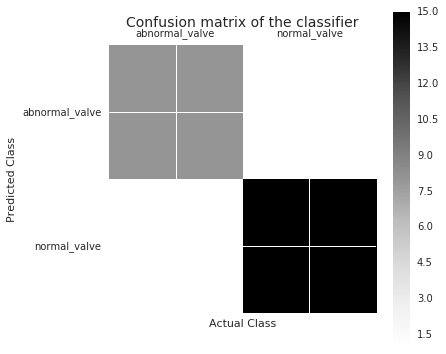

In [12]:
#Calculate Confusion matrix
cmlabels = list(set(labels))
cm = confusion_matrix(image_label_predicted, image_label_test, cmlabels)
print('Confusion matrix of the classifier')
print(cm)

# Visualize Confusion matrix
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title(u'Confusion matrix of the classifier', fontsize=14)
fig.colorbar(cax)
ax.set_xticklabels([''] + cmlabels)
ax.set_yticklabels([''] + cmlabels)
plt.xlabel(u'Actual Class')
plt.ylabel(u'Predicted Class')
plt.show()

### 6.3 Let's have a look at those images the model incorrectly predicted:

Below are images incorrectly predicted, with their actual class:


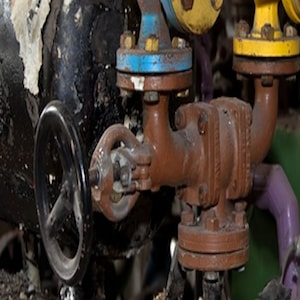

'images/normal_valve_36.jpg'

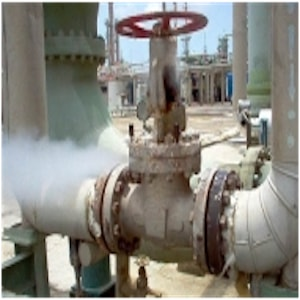

'images/abnormal_valve_43.jpg'

In [13]:
# Create a list containing bad predictions
wrong_prediction_index_list = []
for i in range(len(image_label_predicted)): 
  if image_label_predicted[i] != image_label_test[i]: wrong_prediction_index_list.append(i)
wrong_image_index_list = []
for j in range(len(wrong_prediction_index_list)): 
  for k in range(len(features)):
    if np.array_equal(image_features_test[wrong_prediction_index_list[j]], features[k]): wrong_image_index_list.append(k)

# Display image & acutal class below the image
print('================================================================')
print('Below are images incorrectly predicted, with their actual class:')
print('================================================================')
for m in range(len(wrong_image_index_list)): 
    display(Image(list_images[wrong_image_index_list[m]]), list_images[wrong_image_index_list[m]])

***[Take Away Question] Is there ways to further improve the prediction accuracy? Yes there are! You can find more from ... advanced GCP courses.***

# Congratulations! You are now equipped with practical skills to carry out deep leaning image analysis in real world!

### You have learnt:

* Deep Learning Basics for Image Analysis
* Real World Image Analysis Needs
* Idea of Transfer Learning
* Architecture of Transfer Learning
* Hands-on Datalab Workshop on GCP